In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import shapefile

In [2]:
# Initialize Earth Engine and geemap
#ee.authenticate()
ee.Initialize()

In [3]:
sf = shapefile.Reader('C:/Users/Chancy/Desktop/Ahmedabad_City.shp')
feature = sf.shapeRecords()[0]  # Assuming there is only one feature in the shapefile
aoi = ee.Geometry.Polygon(feature.shape.__geo_interface__['coordinates'])
#print(aoi)

In [4]:
# Define functions to calculate various indices
def ndvi(img):
    return img.normalizedDifference(['B5', 'B4']).rename('NDVI')

def ndbi(img):
    return img.normalizedDifference(['B5', 'B6']).rename('NDBI')

def ndwi(img):
    return img.normalizedDifference(['B3', 'B5']).rename('NDWI')

def lsti(img):
    # Convert the image to radiance
    radiance = ee.Image(img.multiply(0.0003342).add(0.1))
    # Calculate the temperature in Celsius
    Celsius = ee.Image(radiance.select('B10').multiply(0.1)).expression('1 / (B10 / 14380 + 1.0) - 273.15', {'B10': radiance.select('B10')})
    return Celsius.rename('LSTI')

In [5]:
# Define the time range for the analysis
start_date = '2013-01-01'
end_date = '2022-12-31'

In [6]:
# Load Landsat 8 imagery for the study area and time range
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterDate(start_date, end_date).filterBounds(aoi)

In [7]:
# Map the functions over the collection
ndvi_collection = collection.map(ndvi)
ndbi_collection = collection.map(ndbi)
ndwi_collection = collection.map(ndwi)
lsti_collection = collection.map(lsti)

In [8]:
# Calculate the difference between the first and last image in each index collection
ndvi_first = ndvi_collection.sort('system:time_start').first()
ndvi_last = ee.Image(ndvi_collection.sort('system:time_start', False).toList(ndvi_collection.size()).get(-1))

ndbi_first = ndbi_collection.sort('system:time_start').first()
ndbi_last = ee.Image(ndbi_collection.sort('system:time_start', False).toList(ndbi_collection.size()).get(-1))

ndwi_first = ndwi_collection.sort('system:time_start').first()
ndwi_last = ee.Image(ndwi_collection.sort('system:time_start', False).toList(ndwi_collection.size()).get(-1))

lsti_first = lsti_collection.sort('system:time_start').first()
lsti_last = ee.Image(lsti_collection.sort('system:time_start', False).toList(lsti_collection.size()).get(-1))


In [9]:
# Get the pixel values for each index at the first and last time steps
ndvi_values = ndvi_first.addBands(ndvi_last).reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=aoi,
  scale=30, 
    maxPixels=1e9,
).get('NDVI').getInfo()

ndbi_values = ndbi_first.addBands(ndbi_last).reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=aoi,
    maxPixels=1e9,
  scale=30
).get('NDBI').getInfo()

ndwi_values = ndwi_first.addBands(ndwi_last).reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=aoi,
    maxPixels=1e9,
  scale=30
).get('NDWI').getInfo()

lsti_values = lsti_first.addBands(lsti_last).reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=aoi,
    maxPixels=1e9,
  scale=30
).get('LSTI').getInfo()

In [10]:
df = pd.DataFrame({
    'NDVI': ndvi_values,
    'NDBI': ndbi_values,
    'NDWI': ndwi_values,
    'LSTI': lsti_values,
})

In [11]:
df

,NDVI,NDBI,NDWI,LSTI
0,0.279657,-0.045263,-0.380535,-272.150080
1,0.226519,-0.038160,-0.320522,-272.150079
2,0.207223,-0.020237,-0.300602,-272.150079
3,0.204154,0.010382,-0.298547,-272.150079
4,0.246887,0.011048,-0.319085,-272.150080
...,...,...,...,...
102727,0.649085,0.258692,-0.614941,-272.150079
102728,0.389341,0.051085,-0.451628,-272.150079
102729,0.377377,0.037649,-0.425688,-272.150079
102730,0.396698,0.037855,-0.442631,-272.150079


In [12]:
corr_matrix = df.corr()
print(corr_matrix)

          NDVI      NDBI      NDWI      LSTI
NDVI  1.000000  0.689809 -0.942270  0.199827
NDBI  0.689809  1.000000 -0.464822  0.631389
NDWI -0.942270 -0.464822  1.000000  0.040045
LSTI  0.199827  0.631389  0.040045  1.000000


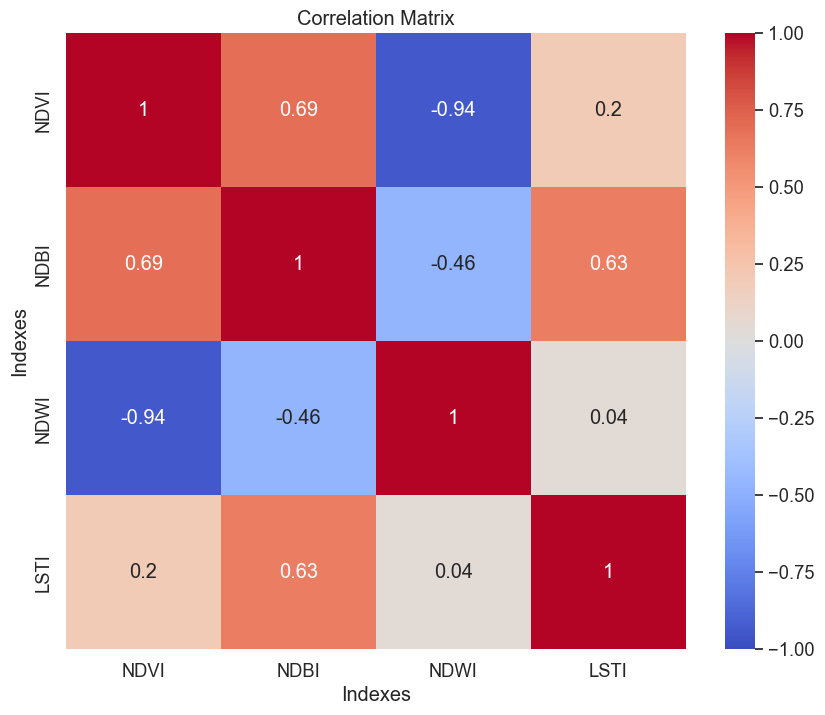

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# create the heatmap using Seaborn
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)

# set the title and axis labels
ax.set_title('Correlation Matrix')
ax.set_xlabel('Indexes')
ax.set_ylabel('Indexes')
plt.show()

In [14]:
ndvi_diff = ndvi_first.subtract(ndvi_last).rename('NDVI_diff')
ndbi_diff = ndbi_first.subtract(ndbi_last).rename('NDBI_diff')
ndwi_diff = ndwi_first.subtract(ndwi_last).rename('NDWI_diff')
lsti_diff = lsti_first.subtract(lsti_last).rename('NDWI_diff')

In [15]:
corr_matrix

,NDVI,NDBI,NDWI,LSTI
NDVI,1.000000,0.689809,-0.942270,0.199827
NDBI,0.689809,1.000000,-0.464822,0.631389
NDWI,-0.942270,-0.464822,1.000000,0.040045
LSTI,0.199827,0.631389,0.040045,1.000000


In [16]:
weights_matrix = corr_matrix.to_numpy()
weights_matrix

array([[ 1.        ,  0.68980908, -0.94226971,  0.19982721],
       [ 0.68980908,  1.        , -0.46482178,  0.63138909],
       [-0.94226971, -0.46482178,  1.        ,  0.04004549],
       [ 0.19982721,  0.63138909,  0.04004549,  1.        ]])

In [17]:
# Multiply the image bands with the weights matrix
weighted_bands = ndvi_diff.multiply(weights_matrix[0][0]) \
    .add(ndbi_diff.multiply(weights_matrix[0][1])) \
    .add(ndwi_diff.multiply(weights_matrix[0][2])) \
    .add(lsti_diff.multiply(weights_matrix[0][3]))

# Sum the weighted bands to get the impact score
impact_score = weighted_bands.reduce(ee.Reducer.sum())

In [18]:
impact_scale = ee.Image.constant(0).where(impact_score.lt(-2), 5) \
    .where(impact_score.gte(-2).And(impact_score.lt(-1)), 4) \
    .where(impact_score.gte(-1).And(impact_score.lt(0)), 3) \
    .where(impact_score.gte(0).And(impact_score.lt(1)), 2) \
    .where(impact_score.gte(1).And(impact_score.lt(2)), 1) \
    .where(impact_score.gt(2), 0) \
    .rename('impact_scale')

In [19]:
# Clip the image to the area of interest
impact_scale_clipped = impact_scale.clip(aoi)

In [20]:
legend_dict = {
    "Very Low Impact": "#006837",
    "Low Impact": "#1a9850",
    "Medium Impact": "#fed976",
    "High Impact": "#fd8d3c",
    "Very High Impact": "#f03b20",
}
viz_params = {
    'min': 0,
    'max': 4,
    'palette': ['#006837', '#1a9850', '#fed976', '#fd8d3c', '#f03b20']
}

In [21]:
Map = geemap.Map(center=[23.0225, 72.5714], zoom=13)
# Add the clipped and styled impact scale layer to the map
Map.addLayer(impact_scale_clipped, viz_params, 'Impact Scale')
Map.addLayerControl()
Map.add_legend(legend_dict=legend_dict)
Map

Map(center=[23.0225, 72.5714], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

In [22]:
# Calculate the area for each class
class1_area = impact_scale_clipped.eq(0).multiply(ee.Image.pixelArea()).reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, scale=30).get('impact_scale')
class2_area = impact_scale_clipped.eq(1).multiply(ee.Image.pixelArea()).reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, scale=30).get('impact_scale')
class3_area = impact_scale_clipped.eq(2).multiply(ee.Image.pixelArea()).reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, scale=30).get('impact_scale')
class4_area = impact_scale_clipped.eq(3).multiply(ee.Image.pixelArea()).reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, scale=30).get('impact_scale')
class5_area = impact_scale_clipped.eq(4).multiply(ee.Image.pixelArea()).reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, scale=30).get('impact_scale')

# Calculate the total area of the region of interest
total_area = class1_area.getInfo() + class2_area.getInfo() + class3_area.getInfo() + class4_area.getInfo() + class5_area.getInfo()
total_area = float(total_area)

# Calculate the percentage of each class
class1_percent = (class1_area.getInfo() / total_area) * 100
class2_percent = (class2_area.getInfo() / total_area) * 100
class3_percent = (class3_area.getInfo() / total_area) * 100
class4_percent = (class4_area.getInfo() / total_area) * 100
class5_percent = (class5_area.getInfo() / total_area) * 100

In [23]:
# Print the area and percentage for each class
print('Very Low Impact area:', class1_area.getInfo(), 'm^2, percentage:', round(class1_percent, 2), '%')
print('Low Impact area:', class2_area.getInfo(), 'm^2, percentage:', round(class2_percent, 2), '%')
print('Medium Impact area:', class3_area.getInfo(), 'm^2, percentage:', round(class3_percent, 2), '%')
print('High Impact area:', class4_area.getInfo(), 'm^2, percentage:', round(class4_percent, 2), '%')
print('Very High Impact area:', class5_area.getInfo(), 'm^2, percentage:', round(class5_percent, 2), '%')

Very Low Impact area: 0 m^2, percentage: 0.0 %
Low Impact area: 125797.2251237458 m^2, percentage: 0.14 %
Medium Impact area: 56221879.42978059 m^2, percentage: 60.86 %
High Impact area: 35936009.48517223 m^2, percentage: 38.9 %
Very High Impact area: 93142.02342194201 m^2, percentage: 0.1 %
